In [6]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

In [7]:
%matplotlib inline

from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from matplotlib.patches import ConnectionPatch
from scipy.stats import pearsonr
from scipy import stats, signal
from loading import load_session_data
from target import build_tgt_matrix, get_spike_counts, build_silence_and_noise_events,\
        get_idxs_of_event_periods, build_silence_matrix, get_spike_times_at
np.set_printoptions(suppress=True)

In [8]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [26]:
# def get_unit_AM_for_periods(tl, periods, pulses, spike_times, bin_size, mode='sequence'):
#     # pulses for each period (list of arrays)
#     pulses_by_period = get_spike_times_at(tl, pulses, periods, mode='sequence')
#     pulses_by_period = np.array([item for sublist in pulses_by_period for item in sublist])  # flatten

#     # binning for activity matrix - TODO not correct!
#     bin_size = 0.05/3
#     bc_amx   = int(30*(1/bin_size))  # 30 secs
#     bins_amx = np.linspace(0, bin_size*bc_amx, bc_amx+1)

#     # create empty AM
#     unit_AM  = np.zeros([len(spike_times.keys()), len(bins_amx) - 1])
#     for i, (unit_name, all_spikes) in enumerate(spike_times.items()):
#         # spikes for each silence period  (list of arrays)
#         spikes_by_period = get_spike_times_at(tl, all_spikes, periods, mode='overlay')

#         # combine all spikes in overlayed spiketrain
#         spikes_over = np.array([item for sublist in adj_spikes for item in sublist])  # flatten to one array
#         spikes_over = np.sort(spikes_over)

#         # convert overlayed spike times into binned FR (60 Hz)
#         spikes_binned, _ = np.histogram(spikes_over, bins=bins_amx)
#         spikes_binned = stats.zscore(spikes_binned)
#         unit_AM[i] = spikes_binned
        
#     return pulses_over, unit_AM

In [120]:
def get_pop_resp_profile_mx(session, unit_names, hw, bc):
    animal      = session.split('_')[0]
    h5_file     = os.path.join(source, animal, session, session + '.h5')
            
    bins = np.linspace(-hw, hw, bc)
    profile_mx = np.zeros([len(unit_names), bc - 1])
    for i, unit_name in enumerate(unit_names):
        with h5py.File(h5_file, 'r') as f:
            shuffled = np.array(f['units'][unit_name]['psth_shuffled_micro_in_silence'])
            profiles = np.array(f['units'][unit_name]['psth_profiles_silence'])

        fr_mean = shuffled[:, 1]
        fr_std  = shuffled[:, 2]
        fr_prof = profiles.mean(axis=0)
        profile_mx[i] = (fr_prof - fr_mean)/fr_std  # z-scored
        
        # remove non-significant bins
        idxs_non_sign = np.where((fr_prof > shuffled[:, 3]) & (fr_prof < shuffled[:, 4]))[0]
        profile_mx[i, idxs_non_sign] = 0
        
    return profile_mx, bins

In [118]:
def get_unit_AM_for_period(tl, p_start, p_end, spike_times, bin_size=0.05/3):
    t_start  = p_start
    bc_amx   = int((p_end - p_start)/bin_size)
    t_end    = t_start + bin_size*bc_amx
    bins_amx = np.linspace(t_start, t_end, bc_amx+1)
    unit_names = list(spike_times.keys())
    
    unit_act_matrix = np.zeros([len(unit_names), len(bins_amx) - 1])
    for i, unit_name in enumerate(unit_names):
        spikes = spike_times[unit_name]
        spikes = spikes[(spikes > t_start) & (spikes < t_end)]

        vals, _ = np.histogram(spikes, bins=bins_amx + 0*bin_size)
        if not (vals == 0).all():
            unit_act_matrix[i] = vals
        
    return unit_act_matrix, bins_amx

In [46]:
sessions = [s for s in selected_008229.keys()]
sessions.sort()
sessions

['008229_hippoSIT_2022-05-16_20-36-44',
 '008229_hippoSIT_2022-05-17_21-44-43',
 '008229_hippoSIT_2022-05-18_14-36-18',
 '008229_hippoSIT_2022-05-20_15-54-39']

In [47]:
session = sessions[0]

In [11]:
session_data = load_session_data(session)

tl = session_data['tl']
trials = session_data['trials']
cfg = session_data['cfg']
aeps_events = session_data['aeps_events']
tgt_matrix = session_data['tgt_matrix']
single_units = session_data['single_units']
spike_times = session_data['spike_times']
unit_names = session_data['unit_names']
h5_file = session_data['h5_file']

Text(0.5, 1.0, 'Resp. profile matrix for 2022-05-16')

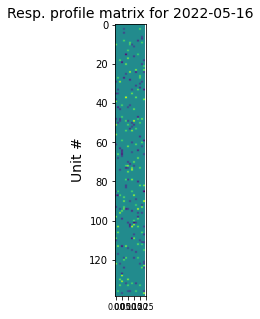

In [121]:
hw, bc = 0.25, 31
profile_mx, bins_prof = get_pop_resp_profile_mx(session, unit_names, hw, bc)
#profile_mx[np.abs(profile_mx) < 0] = 0  # reduce profile noise?
profile_mx_half = profile_mx[:, 15:]

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(profile_mx_half)
ax.set_ylabel('Unit #', fontsize=14)
ax.set_xticks(np.arange(len(bins_prof[15::3]))*3)
_ = ax.set_xticklabels(["%.2f" % b for b in bins_prof[15::3]], fontsize=8)
ax.set_title("Resp. profile matrix for %s" % session[-19:-9], fontsize=14)

In [87]:
# all silence fake pulses
s_offset, latency = aeps_events[0][0], 0.25
drift = ((aeps_events[:, 0] - s_offset) % latency)[-1]
p_sil, p_noi, p_bgr, p_tgt = build_silence_and_noise_events(tl, s_offset, latency, drift)

# all silence periods
periods = get_idxs_of_event_periods(tl, 0)

engrams = []
lengths = []
for period in periods:
    p_start, p_end = tl[period[0]][0], tl[period[1]][0]

    # pulses inside the period 
    pulses = p_sil[(p_sil > p_start) & (p_sil < p_end)]  # times in seconds

    # unit AM, binned
    unit_AM, bins_amx = get_unit_AM_for_period(tl, pulses[0], pulses[-1] + 0.25, spike_times, bin_size=0.05/3)

    # collect engrams
    p_count = int((len(bins_amx) - 1)/15)
    for i in range(p_count):
        engrams.append(unit_AM[:, i*15:i*15 + 15])
    lengths.append(p_count)

Text(0.5, 0, 'Time in silence, bins')

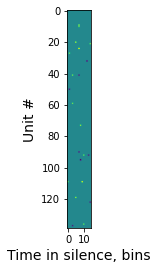

In [129]:
# look at one engram
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.imshow(engrams[0]*profile_mx_half)  # just created
ax.set_ylabel('Unit #', fontsize=14)
ax.set_xlabel('Time in silence, bins', fontsize=14)  

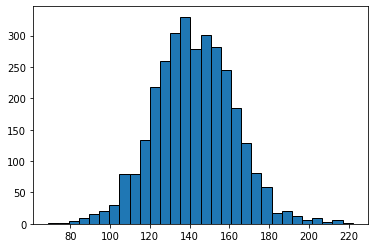

In [96]:
# look at spike count distribution
spk_counts = np.array([e.sum() for e in engrams])
_ = plt.hist(spk_counts, bins=30, edgecolor='black')

In [152]:
sim_mx = np.zeros([len(engrams), len(engrams)])
for i, e1 in enumerate(engrams):
    for j, e2 in enumerate(engrams):
        e1_f = (e1 * profile_mx_half).flatten() 
        e2_f = (e2 * profile_mx_half).flatten()
        e1_nonz_count = len(np.where(np.abs(e1_f) > 0)[0])
        e2_nonz_count = len(np.where(np.abs(e2_f) > 0)[0])
        sim_mx[i, j] = np.abs(e1_f - e2_f).sum() / (e1_nonz_count + e2_nonz_count) # distance
    print('%d; ' % i, end='')

0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 100; 101; 102; 103; 104; 105; 106; 107; 108; 109; 110; 111; 112; 113; 114; 115; 116; 117; 118; 119; 120; 121; 122; 123; 124; 125; 126; 127; 128; 129; 130; 131; 132; 133; 134; 135; 136; 137; 138; 139; 140; 141; 142; 143; 144; 145; 146; 147; 148; 149; 150; 151; 152; 153; 154; 155; 156; 157; 158; 159; 160; 161; 162; 163; 164; 165; 166; 167; 168; 169; 170; 171; 172; 173; 174; 175; 176; 177; 178; 179; 180; 181; 182; 183; 184; 185; 186; 187; 188; 189; 190; 191; 192; 193; 194; 195; 196; 197; 198; 199; 200; 201; 202; 203; 204; 205; 206; 207; 208; 209; 210; 211; 212; 213; 214; 215; 216; 217; 218; 219; 220; 221; 

1552; 1553; 1554; 1555; 1556; 1557; 1558; 1559; 1560; 1561; 1562; 1563; 1564; 1565; 1566; 1567; 1568; 1569; 1570; 1571; 1572; 1573; 1574; 1575; 1576; 1577; 1578; 1579; 1580; 1581; 1582; 1583; 1584; 1585; 1586; 1587; 1588; 1589; 1590; 1591; 1592; 1593; 1594; 1595; 1596; 1597; 1598; 1599; 1600; 1601; 1602; 1603; 1604; 1605; 1606; 1607; 1608; 1609; 1610; 1611; 1612; 1613; 1614; 1615; 1616; 1617; 1618; 1619; 1620; 1621; 1622; 1623; 1624; 1625; 1626; 1627; 1628; 1629; 1630; 1631; 1632; 1633; 1634; 1635; 1636; 1637; 1638; 1639; 1640; 1641; 1642; 1643; 1644; 1645; 1646; 1647; 1648; 1649; 1650; 1651; 1652; 1653; 1654; 1655; 1656; 1657; 1658; 1659; 1660; 1661; 1662; 1663; 1664; 1665; 1666; 1667; 1668; 1669; 1670; 1671; 1672; 1673; 1674; 1675; 1676; 1677; 1678; 1679; 1680; 1681; 1682; 1683; 1684; 1685; 1686; 1687; 1688; 1689; 1690; 1691; 1692; 1693; 1694; 1695; 1696; 1697; 1698; 1699; 1700; 1701; 1702; 1703; 1704; 1705; 1706; 1707; 1708; 1709; 1710; 1711; 1712; 1713; 1714; 1715; 1716; 1717; 1718

2919; 2920; 2921; 2922; 2923; 2924; 2925; 2926; 2927; 2928; 2929; 2930; 2931; 2932; 2933; 2934; 2935; 2936; 2937; 2938; 2939; 2940; 2941; 2942; 2943; 2944; 2945; 2946; 2947; 2948; 2949; 2950; 2951; 2952; 2953; 2954; 2955; 2956; 2957; 2958; 2959; 2960; 2961; 2962; 2963; 2964; 2965; 2966; 2967; 2968; 2969; 2970; 2971; 2972; 2973; 2974; 2975; 2976; 2977; 2978; 2979; 2980; 2981; 2982; 2983; 2984; 2985; 2986; 2987; 2988; 2989; 2990; 2991; 2992; 2993; 2994; 2995; 2996; 2997; 2998; 2999; 3000; 3001; 3002; 3003; 3004; 3005; 3006; 3007; 3008; 3009; 3010; 3011; 3012; 3013; 3014; 3015; 3016; 3017; 3018; 3019; 3020; 3021; 3022; 3023; 3024; 3025; 3026; 3027; 3028; 3029; 3030; 3031; 3032; 3033; 3034; 3035; 3036; 3037; 3038; 3039; 3040; 3041; 3042; 3043; 3044; 3045; 3046; 3047; 3048; 3049; 3050; 3051; 3052; 3053; 3054; 3055; 3056; 3057; 3058; 3059; 3060; 3061; 3062; 3063; 3064; 3065; 3066; 3067; 3068; 3069; 3070; 3071; 3072; 3073; 3074; 3075; 3076; 3077; 3078; 3079; 3080; 3081; 3082; 3083; 3084; 3085

(0.0, 500.0)

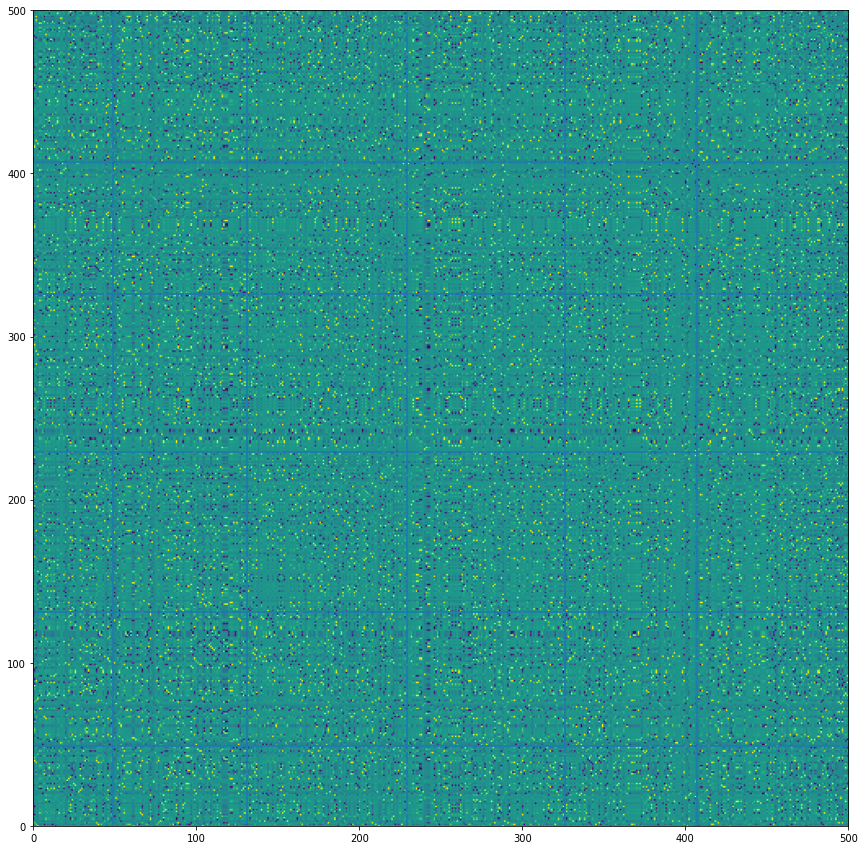

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.imshow(sim_mx_out[0:1500, 0:1500])
l_curr = 0
for l in lengths[:]:
    l_curr += l
    ax.axhline(l_curr)
    ax.axvline(l_curr)
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)

(array([      4.,       0.,       0.,       2.,      12.,     168.,
        9740427.,      14.,      10.,       4.]),
 array([-4321529.79880765, -3618986.01201219, -2916442.22521674,
        -2213898.43842128, -1511354.65162583,  -808810.86483037,
         -106267.07803492,   596276.70876054,  1298820.495556  ,
         2001364.28235145,  2703908.06914691]),
 <BarContainer object of 10 artists>)

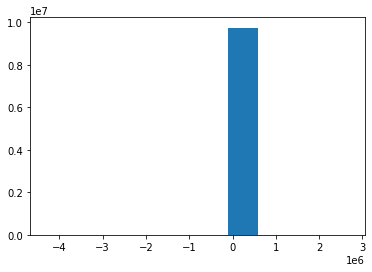

In [137]:
plt.hist(sim_mx.flatten())

In [138]:
sim_mx_out = sim_mx.copy()
sim_mx_out[sim_mx_out < -100] = -100
sim_mx_out[sim_mx_out > 100] = 100

In [139]:
sim_mx_out.max()

100.0